In [1]:
import numpy
import torch
import matplotlib.pyplot as plt
from torch import distributions as D

tkwargs = {"dtype": torch.float64, "device": 'cpu'}

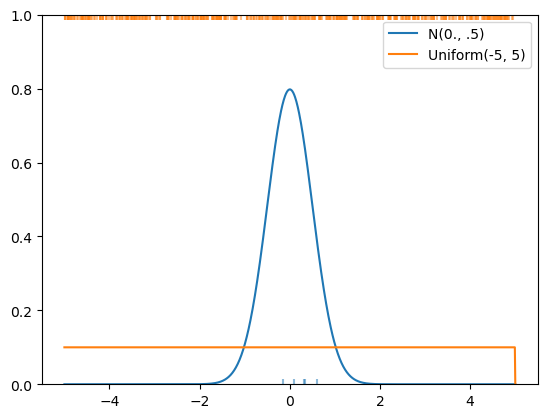

In [6]:
num_obs_p = 5
num_obs_m = 500
p = D.Normal(loc=0, scale=.5)
# p = D.Uniform(torch.tensor([-5.0]), torch.tensor([5.0]))
m = D.Uniform(torch.tensor([-5.0]), torch.tensor([5.0]))

p_samples = p.sample((num_obs_p, 1)).to(**tkwargs)
m_samples = m.sample((num_obs_m, )).to(**tkwargs)

plt.scatter(p_samples, torch.zeros_like(p_samples), alpha=0.5, marker='|', s=50)
plt.scatter(m_samples, 1. * numpy.ones_like(m_samples), alpha=0.5, marker='|', s=50)

x_dense = torch.linspace(-5., 5., 1000, **tkwargs).reshape(-1, 1)
plt.plot(x_dense, torch.exp(p.log_prob(x_dense)), label='N(0., .5)')
plt.plot(x_dense, torch.exp(m.log_prob(x_dense)), label='Uniform(-5, 5)')

plt.ylim(0., 1.0)
plt.legend();

14.589872360229492
14.87534845982921


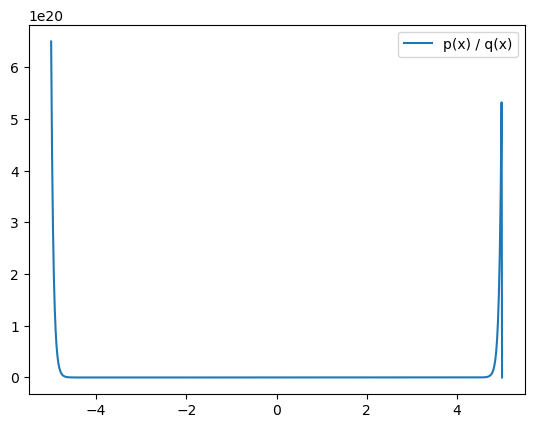

In [7]:
plt.plot(x_dense, (m.log_prob(x_dense) - p.log_prob(x_dense)).exp(), label= "p(x) / q(x)")
kl_true = torch.distributions.kl_divergence(m, p)
print(kl_true.item())
kl_mc = (m.log_prob(m_samples) - p.log_prob(m_samples)).mean()
print(kl_mc.item())
plt.legend();

In [8]:
from torch import nn


class MLP(nn.Module):

    def __init__(
        self,
        input_dim,
        output_dim,
        dtype=torch.float64,
        device='cpu'
    ):
        super(MLP, self).__init__()
        self.tkwargs = {"dtype": dtype, "device": device}
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ELU(),
            nn.Linear(32, 32),
            nn.ELU(),
            nn.Linear(32, 32),
            nn.ELU(),
            nn.Linear(32, output_dim),
        )
        self.model.to(**self.tkwargs)
        
    def forward(self, x):
        logits = self.model(x)
        return logits
    
    def fit(self, x, z, w, batch_size=256, S=100):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        loss_fn = torch.nn.CrossEntropyLoss(reduction='none')

        train_tensors = [x, z, w]
        train_dataset = torch.utils.data.TensorDataset(*train_tensors)
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        )

        self.train()
        losses = []
        for _ in range(S):
            for _, (inputs, targets, weights) in enumerate(train_dataloader):
                optimizer.zero_grad()

                outputs = self(inputs)
                batch_loss = loss_fn(
                    outputs, targets
                )
                batch_loss = (batch_loss * weights / weights.sum()).sum()
                batch_loss.backward()
                optimizer.step()
                losses.append(batch_loss.item())
        plt.plot(losses)
        self.eval()

In [9]:
x = torch.cat([p_samples, m_samples]).to(**tkwargs)

z_p = torch.empty(num_obs_p, dtype=torch.long).fill_(0)
z_m = torch.empty(num_obs_m, dtype=torch.long).fill_(1)
z = torch.cat([z_p, z_m])

s_p = p_samples.shape[0]
s_m = m_samples.shape[0]
w_p = [(s_p + s_m) / s_p] * s_p
w_m = [(s_p + s_m) / s_m] * s_m
w = torch.tensor(w_p + w_m, **tkwargs)
w = w / w.mean()
# w = torch.ones_like(z, **tkwargs)

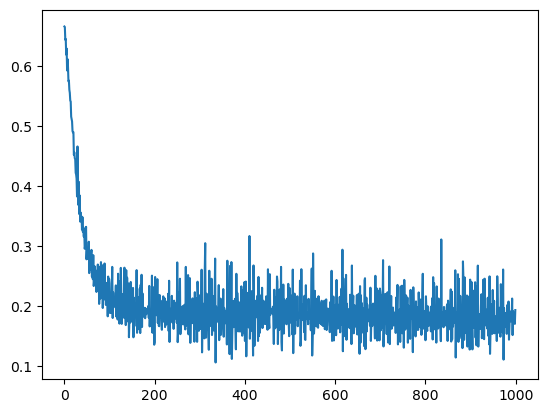

In [10]:
estimator = MLP(input_dim=1, output_dim=2)
estimator.fit(x, z, w, S=500)

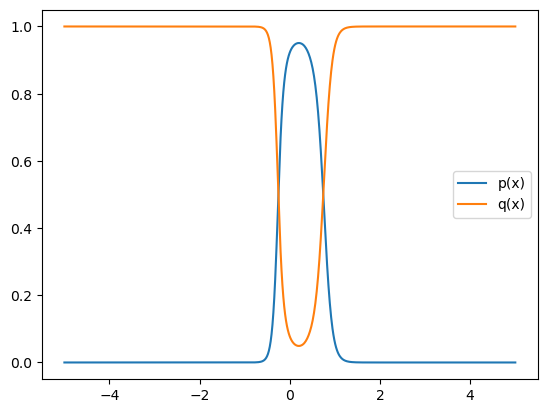

In [11]:
with torch.no_grad():
    logits = estimator(x_dense)
probs = torch.softmax(logits, dim=-1)
plt.plot(x_dense, probs[:, 0], label='p(x)')
plt.plot(x_dense, probs[:, 1], label='q(x)')
plt.legend();

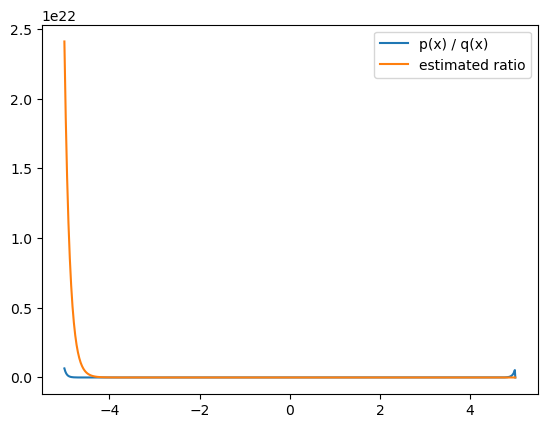

In [12]:
plt.plot(x_dense, (m.log_prob(x_dense) - p.log_prob(x_dense)).exp(), label= "p(x) / q(x)")
plt.plot(x_dense, (logits[:, 1] - logits[:, 0]).exp(), label='estimated ratio')
# plt.plot(x_dense, s_p / s_m *(logits[:, 1] - logits[:, 0]).exp(), label='estimated ratio')
plt.legend();

In [13]:
with torch.no_grad():
    log_prob = estimator(m_samples)
(log_prob[:, 1] - log_prob[:, 0]).mean()
# (log_prob[:, 1] - log_prob[:, 0] + torch.log(torch.tensor([s_p / s_m]))).mean()

tensor(21.7290, dtype=torch.float64)